In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# from torchvision.datasets import MNIST
from torchvision import transforms
import torch
from torch.utils.data import DataLoader, Dataset

from model import *

import pandas as pd

import matplotlib.pyplot as plt
import torch.nn as nn

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    device = torch.device('cpu')
    print("CUDA not available, using CPU")

print(f"Device: {device}")

Using GPU: NVIDIA GeForce RTX 2080 Ti
CUDA Version: 12.1
Device: cuda


In [2]:
device

device(type='cuda')

In [3]:
from model import create_lightweight_detector

yolo = create_lightweight_detector().to(device)

In [4]:
df = pd.read_parquet("trailer-53ft-data-large/data.parquet")

print(df.head())

           name               image_path               scene_path  \
0  ywS7Z8PYDwzU  images/ywS7Z8PYDwzU.png  scenes/ywS7Z8PYDwzU.xml   
1  qVq9KrxI6cUJ  images/qVq9KrxI6cUJ.png  scenes/qVq9KrxI6cUJ.xml   
2  t4etaisoU0XU  images/t4etaisoU0XU.png  scenes/t4etaisoU0XU.xml   
3  EavwTEpzWeZF  images/EavwTEpzWeZF.png  scenes/EavwTEpzWeZF.xml   
4  N1bhJZadcJRJ  images/N1bhJZadcJRJ.png  scenes/N1bhJZadcJRJ.xml   

   volume_occupancy  floor_occupancy          scenario  
0          0.265683         0.399375  mixed-cargo-type  
1          0.001135         0.008125  mixed-cargo-type  
2          0.015896         0.028125  mixed-cargo-type  
3          0.511350         0.629687  mixed-cargo-type  
4          0.240704         0.325000  mixed-cargo-type  


In [5]:
df["volume_occupancy"].describe()

count    5910.000000
mean        0.299157
std         0.262925
min         0.000000
25%         0.054783
50%         0.254329
75%         0.484436
max         0.883399
Name: volume_occupancy, dtype: float64

In [6]:
import matplotlib.pyplot as plt
import torch

def show_rgb_tensor(tensor):
    img = tensor.detach().cpu().numpy()
    
    if img.ndim == 4:
        img = img[0]
    
    if img.shape[0] == 3: 
        img = img.transpose(1, 2, 0)
    
    img = (img - img.min()) / (img.max() - img.min())
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [27]:
from PIL import Image
import os
import numpy as np
from torch.utils.data import Dataset

class TrailerDataModule(Dataset):
    def __init__(self, annotations_file, image_dir, transform=None, target_transform=None):
        self.annotations = pd.read_parquet(annotations_file)
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.annotations.iloc[idx, 1])
        image = Image.open(img_path).convert("RGB")
        # label = self.annotations.iloc[idx, 3]

        label = np.digitize(self.annotations.iloc[idx, 3], bins= [0, 0.1, 0.5]) - 1
        

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [28]:
labels = np.digitize(df["volume_occupancy"], bins=[0, 0.1, 0.5])
print("Class distribution:")
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    class_names = ['Low (0-0.1)', 'Medium (0.1-0.5)', 'High (>0.5)']
    if label <= len(class_names):
        print(f"Class {label-1} ({class_names[label-1]}): {count} samples")
print(f"Total samples: {len(labels)}")
np.unique(labels, return_counts=True)

Class distribution:
Class 0 (Low (0-0.1)): 1729 samples
Class 1 (Medium (0.1-0.5)): 2769 samples
Class 2 (High (>0.5)): 1412 samples
Total samples: 5910


(array([1, 2, 3]), array([1729, 2769, 1412]))

In [29]:
from torchvision.transforms import v2
transform = v2.Compose(
    [
        v2.ToTensor(),
        v2.Resize([512, 512]),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
    ]
)
try:
    data = TrailerDataModule(annotations_file="trailer-53ft-data-large/data.parquet", 
                           image_dir="trailer-53ft-data-large", transform=transform)
    print("Using large dataset: trailer-53ft-data-large")
except:
    data = TrailerDataModule(annotations_file="trailer-53ft-data/data.parquet", 
                           image_dir="trailer-53ft-data", transform=transform)
    print("Using regular dataset: trailer-53ft-data")

Using large dataset: trailer-53ft-data-large


/export/home/3hedna/.local/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


0


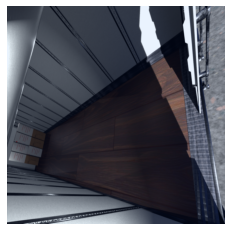

In [57]:

idx = torch.randint(0, len(data), (1,)).item()

print(data[idx][1])
show_rgb_tensor(data[idx][0])


In [11]:
from sklearn.model_selection import train_test_split 

train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
batch_size = 4
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

print(f"Using batch size: {batch_size}")
for X, y in train_dataloader:
    print(f"Input shape: {X.shape}")
    print(f"Label shape: {y.shape}")
    print(f"Memory usage per batch: ~{X.element_size() * X.nelement() / 1024**2:.1f} MB")
    break

torch.Size([70, 3, 224, 224])
torch.Size([70])


In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, balanced_accuracy_score, cohen_kappa_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(yolo.parameters(), lr=1e-2)

scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min',          
    factor=0.1,         
    patience=3,          
    verbose=True,        
    min_lr=1e-9          
)

print(f"Model parameter count: {sum(p.numel() for p in yolo.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in yolo.parameters() if p.requires_grad):,}")

/export/home/3hedna/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [22]:
import gc

def train_loop(dataloader, model, loss_fn, scheduler):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        torch.cuda.empty_cache()
        gc.collect()

        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step(loss)
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def train_with_scheduler(train_dataloader, test_dataloader, model, loss_fn, optimizer, scheduler, epochs):
    train_losses = []
    test_losses = []
    test_accuracies = []
    test_f1_scores = []
    test_balanced_accuracies = []
    test_kappa_scores = []
    learning_rates = []

    for epoch in range(epochs):
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        print(f"Epoch {epoch+1}/{epochs} - LR: {current_lr:.2e}")

        model.train()
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()

            if batch % 10 == 0:
                current = (batch + 1) * len(X)
                print(f"  Batch {batch}: loss: {loss.item():.6f} [{current}/{len(train_dataloader.dataset)}]")

        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        test_loss, correct = 0, 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()

                pred_classes = pred.argmax(1)
                correct += (pred_classes == y).type(torch.float).sum().item()

                all_preds.extend(pred_classes.cpu().numpy())
                all_targets.extend(y.cpu().numpy())

        avg_test_loss = test_loss / len(test_dataloader)
        accuracy = correct / len(test_dataloader.dataset)

        f1 = f1_score(all_targets, all_preds, average='weighted')
        balanced_acc = balanced_accuracy_score(all_targets, all_preds)
        kappa = cohen_kappa_score(all_targets, all_preds)

        test_losses.append(avg_test_loss)
        test_accuracies.append(accuracy)
        test_f1_scores.append(f1)
        test_balanced_accuracies.append(balanced_acc)
        test_kappa_scores.append(kappa)

        scheduler.step(avg_test_loss)

        print(f"Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
        print(f"Accuracy: {accuracy*100:.2f}%, F1: {f1:.4f}, Balanced Acc: {balanced_acc:.4f}, Kappa: {kappa:.4f}")

        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < current_lr:
            print(f"LR reduced from {current_lr:.2e} to {new_lr:.2e}")

    return train_losses, test_losses, test_accuracies, test_f1_scores, test_balanced_accuracies, test_kappa_scores, learning_rates, all_targets, all_preds


In [ ]:
def plot_results(train_losses, test_losses, test_accuracies, test_f1_scores, test_balanced_accuracies, test_kappa_scores, learning_rates, all_targets, all_preds):
    epochs = range(1, len(train_losses) + 1)

    fig = plt.figure(figsize=(20, 12))

    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
    ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(epochs, [acc * 100 for acc in test_accuracies], 'g-', label='Accuracy', linewidth=2)
    ax2.plot(epochs, [f1 * 100 for f1 in test_f1_scores], 'orange', label='F1-Score', linewidth=2)
    ax2.plot(epochs, [ba * 100 for ba in test_balanced_accuracies], 'purple', label='Balanced Acc', linewidth=2)
    ax2.set_title('Classification Metrics (%)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Percentage')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = plt.subplot(2, 3, 3)
    ax3.plot(epochs, test_kappa_scores, 'red', marker='o', markersize=3, linewidth=2)
    ax3.set_title('Cohen\'s Kappa Score', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Kappa Score')
    ax3.grid(True, alpha=0.3)

    ax4 = plt.subplot(2, 3, 4)
    ax4.plot(epochs, learning_rates, 'purple', marker='o', markersize=3, linewidth=2)
    ax4.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate')
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3)

    ax5 = plt.subplot(2, 3, 5)
    cm = confusion_matrix(all_targets, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax5, 
                xticklabels=['Low', 'Medium', 'High'], 
                yticklabels=['Low', 'Medium', 'High'])
    ax5.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Predicted')
    ax5.set_ylabel('Actual')

    ax6 = plt.subplot(2, 3, 6)
    precision, recall, f1_per_class, support = precision_recall_fscore_support(all_targets, all_preds, average=None)
    class_names = ['Low', 'Medium', 'High']
    x = np.arange(len(class_names))
    width = 0.25
    ax6.bar(x - width, precision, width, label='Precision', alpha=0.8)
    ax6.bar(x, recall, width, label='Recall', alpha=0.8)
    ax6.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.8)
    ax6.set_title('Per-Class Metrics', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Classes')
    ax6.set_ylabel('Score')
    ax6.set_xticks(x)
    ax6.set_xticklabels(class_names)
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
    plt.show()


In [23]:
for epoch in range(50):
    train_loop(train_dataloader, yolo, loss_fn, scheduler)

loss: 1.392484  [   70/  344]
loss: 2.337373  [   70/  344]
loss: 1.422312  [   70/  344]
loss: 1.265317  [   70/  344]
loss: 1.365970  [   70/  344]
loss: 1.154135  [   70/  344]
loss: 1.181504  [   70/  344]


KeyboardInterrupt: 

In [37]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    test_loss, correct = 0,0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct/=size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [54]:
def train_and_plot(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    """
    Training function that trains for specified epochs and shows graphs at the end
    """
    print(f"Starting training for {epochs} epochs...")
    
    train_losses = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        model.train()
        train_loss = 0
        train_size = len(train_dataloader.dataset)
        
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_fn(pred, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.item()
            
            if batch % 100 == 0:
                current = (batch + 1) * len(X)
                print(f"loss: {loss.item():>7f}  [{current:>5d}/{train_size:>5d}]")
        
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        test_loss, correct = 0, 0
        test_size = len(test_dataloader.dataset)
        num_batches = len(test_dataloader)
        
        with torch.no_grad():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        test_loss /= num_batches
        accuracy = correct / test_size
        
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)
        
        print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f}")
    
    print(f"\n🎉 Training completed!")
    print(f"Final Test Accuracy: {(100*test_accuracies[-1]):>0.1f}%")
        
    epochs_range = range(1, epochs + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs_range, test_losses, 'r-', label='Test Loss', linewidth=2)
    ax1.set_title('Training and Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs_range, [acc * 100 for acc in test_accuracies], 'g-', label='Test Accuracy', linewidth=2)
    ax2.set_title('Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()
    
    return train_losses, test_losses, test_accuracies



In [56]:
train_and_plot(train_dataloader, test_dataloader, yolo, loss_fn, optimizer, epochs=20)

Starting training for 20 epochs...

Epoch 1/20
loss: 0.000156  [  100/  344]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.094654

Epoch 2/20
loss: 0.000014  [  100/  344]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.100744

Epoch 3/20
loss: 0.000027  [  100/  344]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.104383

Epoch 4/20
loss: 0.000128  [  100/  344]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.117850

Epoch 5/20
loss: 0.000018  [  100/  344]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.110655

Epoch 6/20
loss: 0.000189  [  100/  344]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.114516

Epoch 7/20
loss: 0.000101  [  100/  344]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.121802

Epoch 8/20
loss: 0.000151  [  100/  344]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.098887

Epoch 9/20
loss: 0.000143  [  100/  344]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.104664

Epoch 10/20
loss: 0.000121  [  100/  344]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.103674

Epoch 11/20
loss: 0.000019  [  100/  344]
T

KeyboardInterrupt: 

In [48]:
test(test_dataloader, yolo, loss_fn)

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.095828 



In [68]:
def save(model, file='./model'):
    torch.save(model.state_dict(),file)

In [69]:
save(model)

In [13]:
sample_idx = torch.randint(len(train_data), size= (1,)).item()

pred = model(train_data[sample_idx][0].view(1,1,28,28)).argmax(1).item()
truth = train_data[sample_idx][1]

print(f"Prediction: {pred}. Ground truth: {truth}")

Prediction: 5. Ground truth: 5


In [16]:
t = torch.ones(size=(3,2,))

In [17]:
t

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

In [18]:
n = t.numpy()

In [19]:
n

array([[1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)

In [32]:
t.add_(2)

tensor([[12., 12.],
        [12., 12.],
        [12., 12.]])

In [33]:
n

array([[12., 12.],
       [12., 12.],
       [12., 12.]], dtype=float32)

In [ ]:
# Improved training and testing functions with metric tracking

def train_with_metrics(dataloader, model, loss_fn, optimizer, epoch_num=None):
    """
    Enhanced training function that returns metrics for plotting
    """
    size = len(dataloader.dataset)
    model.train()
    
    # Track metrics
    total_loss = 0
    batch_losses = []
    num_batches = len(dataloader)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Track metrics
        loss_value = loss.item()
        total_loss += loss_value
        batch_losses.append(loss_value)
        
        # Print progress
        if batch % 10 == 0:  # Print more frequently for better monitoring
            current = (batch + 1) * len(X)
            if epoch_num is not None:
                print(f"Epoch {epoch_num:>3} | Loss: {loss_value:>7f} [{current:>5d}/{size:>5d}]")
            else:
                print(f"Loss: {loss_value:>7f} [{current:>5d}/{size:>5d}]")
    
    # Calculate average loss for the epoch
    avg_loss = total_loss / num_batches
    return avg_loss, batch_losses


def test_with_metrics(dataloader, model, loss_fn, verbose=True):
    """
    Enhanced testing function that returns metrics for plotting
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # Calculate metrics
    avg_loss = test_loss / num_batches
    accuracy = correct / size
    
    if verbose:
        print(f"Test Results: Accuracy: {(100*accuracy):>0.1f}%, Avg Loss: {avg_loss:>8f}")
    
    return accuracy, avg_loss


def plot_training_metrics(train_losses, test_losses, test_accuracies, save_path=None):
    """
    Plot training and testing metrics
    """
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
    ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(epochs, [acc * 100 for acc in test_accuracies], 'g-', label='Test Accuracy', linewidth=2)
    ax2.set_title('Test Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()


def plot_batch_losses(batch_losses, save_path=None):
    """
    Plot batch-level losses to see training dynamics
    """
    plt.figure(figsize=(12, 6))
    plt.plot(batch_losses, alpha=0.7, linewidth=1)
    plt.title('Batch-level Training Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Batch loss plot saved to {save_path}")
    
    plt.show()

print("✅ Enhanced training functions with metric tracking loaded!")


In [ ]:
# Complete training loop with metric tracking and plotting
import time

def train_model_with_tracking(model, train_dataloader, test_dataloader, loss_fn, optimizer, 
                             num_epochs=10, plot_every=5, save_plots=True):
    """
    Complete training loop with metric tracking and visualization
    """
    print("🚀 Starting training with metric tracking...")
    print(f"📊 Training for {num_epochs} epochs")
    print(f"🔥 Using device: {device}")
    print("-" * 60)
    
    # Initialize metric storage
    train_losses = []
    test_losses = []
    test_accuracies = []
    all_batch_losses = []
    
    start_time = time.time()
    
    for epoch in range(1, num_epochs + 1):
        epoch_start = time.time()
        
        # Training phase
        print(f"\n📈 Epoch {epoch}/{num_epochs}")
        train_loss, batch_losses = train_with_metrics(train_dataloader, model, loss_fn, optimizer, epoch)
        all_batch_losses.extend(batch_losses)
        train_losses.append(train_loss)
        
        # Testing phase
        test_accuracy, test_loss = test_with_metrics(test_dataloader, model, loss_fn)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # Epoch summary
        epoch_time = time.time() - epoch_start
        print(f"📋 Epoch {epoch} Summary:")
        print(f"   Training Loss: {train_loss:.6f}")
        print(f"   Test Loss: {test_loss:.6f}")
        print(f"   Test Accuracy: {test_accuracy*100:.2f}%")
        print(f"   Time: {epoch_time:.2f}s")
        
        # Plot intermediate results
        if epoch % plot_every == 0 or epoch == num_epochs:
            print(f"\n📊 Plotting metrics after epoch {epoch}...")
            plot_training_metrics(train_losses, test_losses, test_accuracies, 
                                save_path=f"training_progress_epoch_{epoch}.png" if save_plots else None)
    
    total_time = time.time() - start_time
    print(f"\n🎉 Training completed!")
    print(f"⏱️  Total time: {total_time:.2f}s ({total_time/60:.2f} minutes)")
    print(f"🎯 Final test accuracy: {test_accuracies[-1]*100:.2f}%")
    
    # Plot final batch losses
    if len(all_batch_losses) > 0:
        print("\n📈 Plotting batch-level losses...")
        plot_batch_losses(all_batch_losses, 
                         save_path="batch_losses.png" if save_plots else None)
    
    # Return metrics for further analysis
    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
        'batch_losses': all_batch_losses,
        'final_accuracy': test_accuracies[-1],
        'total_time': total_time
    }

print("✅ Complete training loop with tracking ready!")


In [ ]:
# Example: How to use the enhanced training functions

# Option 1: Train a fresh model with tracking
print("🔧 Setting up fresh model for demonstration...")
fresh_model = create_lightweight_detector().to(device)
fresh_optimizer = torch.optim.AdamW(fresh_model.parameters(), lr=1e-3)

# Example training call (uncomment to run):
# training_results = train_model_with_tracking(
#     model=fresh_model,
#     train_dataloader=train_dataloader,
#     test_dataloader=test_dataloader,
#     loss_fn=loss_fn,
#     optimizer=fresh_optimizer,
#     num_epochs=10,          # Number of epochs to train
#     plot_every=5,           # Plot metrics every 5 epochs
#     save_plots=True         # Save plots to files
# )

# Option 2: Continue training your existing model with tracking
print("📊 You can continue training your existing model with:")
print("training_results = train_model_with_tracking(")
print("    model=yolo,")
print("    train_dataloader=train_dataloader,")
print("    test_dataloader=test_dataloader,")
print("    loss_fn=loss_fn,")
print("    optimizer=optimizer,")
print("    num_epochs=20")
print(")")

# Option 3: Just plot metrics for your current training run
print("\n📈 Or test the plotting functions with dummy data:")

# Create some example metrics for demonstration
import numpy as np
epochs = 20
example_train_losses = np.exp(-np.linspace(0, 3, epochs)) + 0.1 * np.random.random(epochs)
example_test_losses = np.exp(-np.linspace(0, 2.5, epochs)) + 0.15 * np.random.random(epochs)
example_accuracies = 1 - np.exp(-np.linspace(0, 3, epochs)) * 0.8 + 0.05 * np.random.random(epochs)

print("\n🎨 Plotting example training curves...")
plot_training_metrics(example_train_losses, example_test_losses, example_accuracies)

print("\n✅ Ready to track your training progress!")


In [ ]:
# Simple training function that shows graphs at the end (based on your existing style)

def train_and_plot(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    """
    Training function that trains for specified epochs and shows graphs at the end
    """
    print(f"Starting training for {epochs} epochs...")
    
    # Lists to store metrics
    train_losses = []
    test_losses = []
    test_accuracies = []
    
    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # TRAINING PHASE
        model.train()
        train_loss = 0
        train_size = len(train_dataloader.dataset)
        
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_fn(pred, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.item()
            
            if batch % 100 == 0:
                current = (batch + 1) * len(X)
                print(f"loss: {loss.item():>7f}  [{current:>5d}/{train_size:>5d}]")
        
        # Calculate average training loss
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # TESTING PHASE (using your existing test logic)
        model.eval()
        test_loss, correct = 0, 0
        test_size = len(test_dataloader.dataset)
        num_batches = len(test_dataloader)
        
        with torch.no_grad():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        test_loss /= num_batches
        accuracy = correct / test_size
        
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)
        
        print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f}")
    
    print(f"\n🎉 Training completed!")
    print(f"Final Test Accuracy: {(100*test_accuracies[-1]):>0.1f}%")
    
    # SHOW GRAPHS AT THE END
    print("\n📊 Showing training graphs...")
    
    epochs_range = range(1, epochs + 1)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs_range, test_losses, 'r-', label='Test Loss', linewidth=2)
    ax1.set_title('Training and Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(epochs_range, [acc * 100 for acc in test_accuracies], 'g-', label='Test Accuracy', linewidth=2)
    ax2.set_title('Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()
    
    return train_losses, test_losses, test_accuracies

print("✅ Simple train_and_plot function ready!")


In [ ]:
# Example: How to use the train_and_plot function

print("🚀 Example usage:")
print()
print("# Train your model and show graphs at the end:")
print("train_losses, test_losses, test_accuracies = train_and_plot(")
print("    train_dataloader=train_dataloader,")  
print("    test_dataloader=test_dataloader,")
print("    model=yolo,")
print("    loss_fn=loss_fn,")
print("    optimizer=optimizer,")
print("    epochs=10")
print(")")
print()
print("# Or train a fresh model:")
print("fresh_model = create_lightweight_detector().to(device)")
print("fresh_optimizer = torch.optim.AdamW(fresh_model.parameters(), lr=1e-3)")
print("train_and_plot(train_dataloader, test_dataloader, fresh_model, loss_fn, fresh_optimizer, epochs=5)")

print("\n✅ Ready to train! Uncomment and run the code above to start training with automatic plotting.")
